In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**LOADING LIBRARIES**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
import seaborn as sns
import string
import pickle
import matplotlib.pyplot as plt
import re
import os
import joblib

**LOADING DATA**

In [ ]:
#loading data into dataframe
with open('./drive/My Drive/RosettaCodeData.csv', errors='ignore') as f:
  data = pd.read_csv(f)

In [ ]:
#previewing dataframe
data.head(5)

,language,code
0,C,#ifndef _CSEQUENCE_H br #define _CSEQUENCE_H b...
1,C,"#include ""csequence.h"" br br static double..."
2,C,#ifndef _WRITETIMINGS_H br #define _WRITETIMIN...
3,C,#include <stdio.h> br #include <stdlib.h> br ...
4,C,#include <stdio.h> br #include <stdlib.h> br #...


**PREPROCESSING**

In [ ]:
#drop rows with missing values
data = data.dropna()

In [ ]:
#previewing value counts of each programming language
data['language'].value_counts(normalize=True)

Python         0.073676
Haskell        0.059352
Perl           0.053046
Go             0.049825
C              0.048557
Ruby           0.046810
Java           0.045610
JavaScript     0.045268
Julia          0.044342
C++            0.041909
Racket         0.040367
Ada            0.040127
C#             0.038654
Scala          0.036975
Kotlin         0.035433
Fortran        0.029881
PowerShell     0.029676
Rust           0.028408
Groovy         0.026557
R              0.025290
Mathematica    0.022959
Swift          0.021383
PureBasic      0.021315
AWK            0.020184
UNIX Shell     0.019258
PHP            0.019224
COBOL          0.013296
VBA            0.012542
MATLAB         0.008396
SQL PL         0.001679
Name: language, dtype: float64

In [ ]:
def preprocess(text):
    """
    Function to preprocess a row of text in dataframe

    Parameters
    ----------
    text: str
      a row of text to preprocess

    Returns
    -------
    text: str
      a row of preprocessed text
    """
    #cast row as string
    text = str(text)
    #replace complex string for comma (complex string was used to avoid csv interpretting commas as new line)
    text = text.replace('!@#$%^&&^%$#@!', ',')
    #remove characters that are non-english, non-numeric or not a space
    text = ''.join([t for t in text if t in string.printable or t==' '])
    #wrap all punctuation by space
    text = re.sub(fr'([{string.punctuation}])', r' \1 ', text)
    #replace any instance of 2 or more spaces with one space
    text = re.sub(r' {2,}', ' ', text)
    #replace br html with newline character
    text = text.replace(' br ', ' \n ')
    #split text on spaces
    text = text.split(' ')
    #remove empty strings
    text = [t for t in text if t!='']
    
    return text

In [ ]:
#apply preprocessing to dataframe
data['code_clean'] = data['code'].apply(preprocess)

In [ ]:
#previewing preprocessed data
data['code_clean']

0        [#, ifndef, _, CSEQUENCE, _, H, \n, #, define,...
1        [#, include, ", csequence, ., h, ", \n, br, st...
2        [#, ifndef, _, WRITETIMINGS, _, H, \n, #, defi...
3        [#, include, <, stdio, ., h, >, \n, #, include...
4        [#, include, <, stdio, ., h, >, \n, #, include...
                               ...                        
29225    [/, *, query, -, rb, ., c, *, /, \n, #, includ...
29226    [#, Rakefile, \n, br, #, To, build, and, run, ...
29227    [/, *, Query, ., scala, *, /, \n, object, Quer...
29228    [/, *, query, -, jni, ., c, *, /, \n, #, inclu...
29229    [#, Makefile, \n, br, #, Edit, these, lines, t...
Name: code_clean, Length: 29182, dtype: object

In [ ]:
#label encoding the target variable
encoder = LabelEncoder()
data['language'] = encoder.fit_transform(data['language'])

In [ ]:
#saving the encoder as a pickle file
with open("./drive/My Drive/encoder.p", "wb") as f:
  pickle.dump(encoder, f)

In [ ]:
#transforming dependent and independent variable to arrays
X = data['code_clean'].values
y = data['language'].values

In [ ]:
#creating training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=100)

In [ ]:
#adding placeholder tokenizer
#since the data is already tokenized, we don't want to tokenize again so this identity tokenizer will simply return the data as is
def identity_tokenizer(text):
    return text

In [ ]:
#initializing the Term Frequency - Inverse Document Frequency Vectorizer
tfidf_vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, max_df=0.25)

In [ ]:
#fitting on and transform the training data
X_tf_train = tfidf_vectorizer.fit_transform(X_train)

In [ ]:
#transforming the test data
X_tf_test = tfidf_vectorizer.transform(X_test)

In [ ]:
#saving vectorizer as pickle file
with open('./drive/My Drive/vectorizer.p', 'wb') as f:
  pickle.dump(tfidf_vectorizer, f)

### Model Building

In [ ]:
#Initializing instance of Support Vector Machine Classifier 
model = SVC(C=1, 
            kernel='linear', 
            verbose=True, 
            probability=True)

In [ ]:
#Fitting model on training data
model.fit(X_tf_train, Y_train)

[LibSVM]

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=True)

In [ ]:
#Scoring model on training data
print(f'Training accuracy: {np.round(100*model.score(X_tf_train, Y_train), 2)}%')

Training accuracy: 97.44%


In [ ]:
#scoring model on testing data
print(f'Testing accuracy: {np.round(100*model.score(X_tf_test, Y_test), 2)}%')

Testing accuracy: 89.57%


In [ ]:
#testing model on random samples from online (in sample folder)
DIRECTORY = './drive/My Drive/sample'

#obtaining filenames from directory
filenames = os.listdir(DIRECTORY)
#isolating files with .txt extension
filenames = [f for f in filenames if f.endswith('.txt')]
#initializing empty list of code snippets
code = list()
#iterating over files
for f in filenames:
  #combine filename with directory name to get filepath
  path = os.path.join(DIRECTORY, f)
  #opening file
  with open(path, 'rb') as file:
    #reading file
    sample = file.readlines()
  #decode binary from file and turn it to string
  sample = [i.decode() for i in sample]
  #replace new-line characters with br
  pattern = re.compile(r'$\n')
  sample = [pattern.sub(' br ', i) for i in sample]
  sample = [re.sub('\n', ' br ', i) if i=='\n' else i for i in sample]
  #join lines to one string
  sample = ' '.join(sample)
  #run the preprocessing on string
  sample = preprocess(sample)
  #append string to code list
  code.append(sample)

#transform preprocessed code snippets using vectorizer
code = tfidf_vectorizer.transform(code)
#use model to predict vectorized code snippets
pred = model.predict(code)
#printing prediction for each filename
for f, p in zip(filenames, pred):
  print(f'File: {f} \nPrediction: {encoder.classes_[p]}\n')

File: awk.txt 
Prediction: AWK

File: unix.txt 
Prediction: UNIX Shell

File: R.txt 
Prediction: R

File: python.txt 
Prediction: Python

File: mathematica.txt 
Prediction: Mathematica

File: pure.txt 
Prediction: PureBasic

File: fortran.txt 
Prediction: Fortran

File: COBOL.txt 
Prediction: COBOL

File: powershell.txt 
Prediction: PowerShell

File: sql.txt 
Prediction: SQL PL

File: rust.txt 
Prediction: Rust

File: go.txt 
Prediction: Go

File: php.txt 
Prediction: PHP

File: python2.txt 
Prediction: Python

File: kotlin.txt 
Prediction: Kotlin

File: julia.txt 
Prediction: Julia

File: scala.txt 
Prediction: Scala

File: ada.txt 
Prediction: Ada

File: haskell.txt 
Prediction: Haskell

File: swift.txt 
Prediction: Swift



**SAVING MODEL**

In [ ]:
#saving model as pickle file
with open('./drive/My Drive/model.p', 'wb') as f:
  pickle.dump(model, f)

In [ ]:
#saving model as joblib file
joblib.dump(model, './drive/My Drive/model.joblib') 

['./drive/My Drive/model.joblib']

**MODEL EVALUTION**

In [ ]:
#predicting test set
Y_pred = model.predict(X_tf_test)

In [ ]:
#obtaining label names from encoder
labels = list(encoder.classes_)

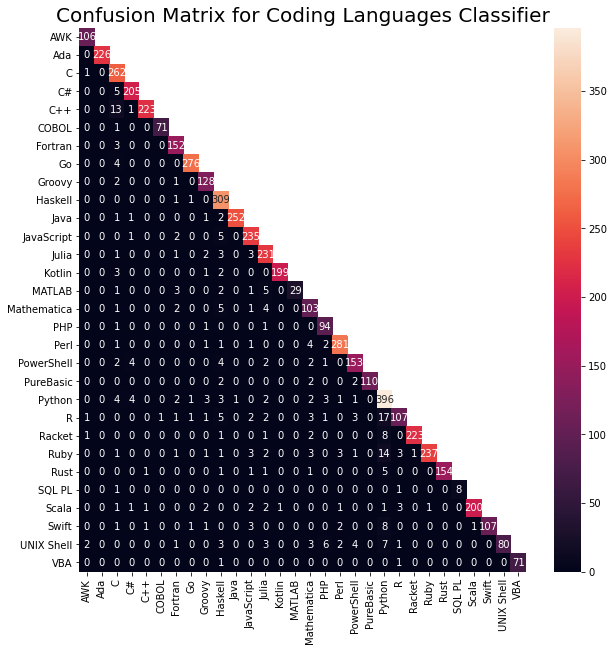

In [ ]:
#plotting confusion matrix
plt.figure(figsize=(10, 10));
cm = confusion_matrix(Y_test, Y_pred)
mask = np.tri(cm.shape[0], k=-1)
mask = np.transpose(mask)
plt.title('Confusion Matrix for Coding Languages Classifier', fontsize=20);
sns.heatmap(cm, annot=True, mask = mask, fmt='g', xticklabels=labels, yticklabels=labels);

In [ ]:
#print classification report
print(classification_report(Y_test, Y_pred, target_names=labels))

              precision    recall  f1-score   support

         AWK       0.95      0.90      0.93       118
         Ada       1.00      0.97      0.98       234
           C       0.85      0.93      0.88       283
          C#       0.94      0.91      0.93       226
         C++       0.97      0.91      0.94       245
       COBOL       0.99      0.91      0.95        78
     Fortran       0.90      0.87      0.89       174
          Go       0.99      0.95      0.97       291
      Groovy       0.89      0.83      0.86       155
     Haskell       0.86      0.89      0.88       346
        Java       0.91      0.95      0.93       266
  JavaScript       0.91      0.89      0.90       264
       Julia       0.84      0.89      0.87       259
      Kotlin       0.99      0.96      0.97       207
      MATLAB       1.00      0.59      0.74        49
 Mathematica       0.73      0.77      0.75       134
         PHP       0.87      0.84      0.85       112
        Perl       0.93    